In [2]:
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import os 
from glob import glob

LOCAL_INPUT_PATH = './'
FLOYD_INPUT_PATH = '/input'

DATA_PATH = FLOYD_INPUT_PATH

TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")

TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)

In [4]:
train_files = glob(os.path.join(TRAIN_DATA, "*.jpg"))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]

test_files = glob(os.path.join(TEST_DATA, "*.jpg"))
test_ids = [s[len(TEST_DATA)+1:-4] for s in test_files]

In [5]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))



In [6]:
import cv2
from PIL import Image
im_size = (256, 256)

def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    #img = img[:, 15:-15, ...]
    img = cv2.resize(img, im_size, interpolation=cv2.INTER_LINEAR)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        #print (fname)
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

Image shape: (256, 256, 3) | image type: uint8 | mask shape: (256, 256) | mask type: uint8


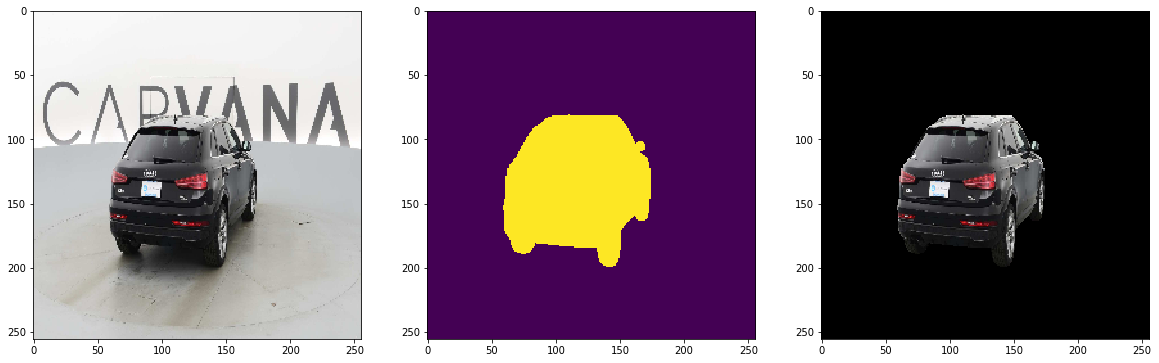

In [7]:
image_id = train_ids[0]

plt.figure(figsize=(20, 20))
img = get_image_data(image_id, "Train")
mask = get_image_data(image_id, "Train_mask")
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked)

In [8]:
def generate_batches(img_ids, batch_size, for_training):
    batch_ims = None 
    batch_ims_mask = None
    
    ds_size = len(img_ids)
    batch_ims = []
    batch_ims_mask = []
    cur_idx = 0
    while cur_idx < len(img_ids):
        batch_train_ids = img_ids[cur_idx: cur_idx + batch_size]
        batch_ims = [get_image_data(image_id, image_type='Train')[np.newaxis,:]
                     for image_id in batch_train_ids]
        if for_training:
            batch_ims_mask = [get_image_data(image_id, image_type='Train_mask')[np.newaxis, :, : , np.newaxis]
                              for image_id in batch_train_ids]
        
        batch_ims = np.concatenate(batch_ims, axis=0)
        batch_ims_mask = np.concatenate(batch_ims_mask, axis=0)
        cur_idx += batch_size

        yield (batch_ims, batch_ims_mask)
    
    
    

In [9]:
def net_input(w=im_size[0], h= im_size[1], d=3):
    
    im = tf.placeholder(tf.float32, shape= (None, w, h, d), name='input_images' )
    im_mask = tf.placeholder(tf.float32, shape=(None, w, h, 1), name='input_images_mask')
    learning_rate = tf.placeholder(tf.float32, shape=None)
    mode = tf.placeholder(tf.bool, shape=None)
    return im, im_mask, learning_rate, mode

    
    

In [10]:

def conv_conv_pool(net, apply_filters, training, ulevel, pooling, activation = tf.nn.relu):
    net_pooled = None
    
    with tf.variable_scope('conv_and_pool_{}'.format(ulevel)):
        for f in apply_filters:
            net = tf.layers.conv2d(net, f, (3,3), strides=1, activation=None, padding='same')
            net = tf.layers.batch_normalization(net, training=training)
            net = activation(net)
            
            #net = tf.nn.dropout(net, 0.8)
        if pooling:
            net_pooled = tf.layers.max_pooling2d(net, (2,2), strides=(2,2))
            
    return net, net_pooled

In [11]:
def upsample_2d(tensor, name, size=(2,2)):

    _, H, W, _ = tensor.shape
    H_multi, W_multi = size
    target_H = int(H * H_multi)
    target_W = int(W * W_multi)
    tensor = tf.image.resize_nearest_neighbor(tensor, (target_H, target_W), name= "upsample_{}".format(name))
    return tensor
    
def upsample_concat(inputA, inputB, name):
    upsample = upsample_2d(inputA, size=(2,2), name=name)
    concat = tf.concat([upsample, inputB], axis=-1, name="concat_{}".format(name))
    return concat

In [12]:
def build_unet(X, training):
    # normalize input
    net = X /127.5 - 1
    
    conv1, pool1 = conv_conv_pool(net, [8, 8], training, ulevel = "1" , pooling=True)
    conv2, pool2 = conv_conv_pool(pool1, [16, 16], training, ulevel ="2", pooling=True)
    conv3, pool3 = conv_conv_pool(pool2, [32, 32], training, ulevel ="3", pooling=True)
    conv4, pool4 = conv_conv_pool(pool3, [64, 64], training, ulevel ="4", pooling=True)
    conv5, _ = conv_conv_pool(pool4, [512, 512], training, ulevel ="5", pooling=False)
    
    up4 = upsample_concat(conv5, conv4, name='_4')
    conv4_4, _ = conv_conv_pool(up4, [64, 64], training, ulevel= "4_4", pooling=False)

    up3 = upsample_concat(conv4_4, conv3, name='_3')
    conv3_3, _ = conv_conv_pool(up3, [32, 32], training, ulevel= "3_3", pooling=False)

    up2 = upsample_concat(conv3_3, conv2, name='_2')
    conv2_2, _ = conv_conv_pool(up2, [16, 16], training, ulevel="2_2", pooling=False)
    
    up1 = upsample_concat(conv2_2, conv1, name='_1')
    conv1_1, _ = conv_conv_pool(up1, [8, 8], training, ulevel="1_1", pooling=False)
    
    return tf.layers.conv2d(conv1_1, 1, (1,1), name='final', activation=tf.nn.sigmoid, padding='same')
    
    
    

In [13]:
def iou(y_pred, y_true):
    H,W, _ = y_pred.get_shape().as_list()[1:]
    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])
 
    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1)  + 1e-7
    
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + 1e-7
    cost = tf.reduce_mean(intersection/denominator)
    tf.summary.scalar('iou_loss', cost)
    return cost 

In [14]:
def make_train_optimization(y_pred, y_true, learning_rate):
    loss = -1 * iou(y_pred, y_true)
    optim = tf.train.AdamOptimizer(learning_rate)
    return optim.minimize(loss)


In [15]:
n_train = len(train_ids)
batch_size = 3
print_every = 10
show_every=100
epoch_count = 3
lr = 0.001

In [16]:
tr_ids, val_ids = train_ids[:int(len(train_ids) * 0.99)], train_ids[int(len(train_ids) * 0.99):]

In [17]:
first_val_id = val_ids[0]
val_im_gen = generate_batches(val_ids, len(val_ids)-1 , for_training=True)
VV, Vy = next(val_im_gen)
print (len(val_ids))

51


In [ ]:
def main():
    tf.reset_default_graph()
    X, y, learning_rate, mode = net_input()
    pred = build_unet(X, training=True)

    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = make_train_optimization(pred, y, learning_rate)
    
    IOU_op = iou(pred, y)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        train_writer = tf.summary.FileWriter('/output/1', sess.graph)
        
        step = 0 
        for epoch_i in range(epoch_count):
            for XX, yy in generate_batches(train_ids, batch_size, for_training=True):
                step += 1
     
                feed_dict = {X: XX, y: yy, mode:True, learning_rate: lr}
                merged = tf.summary.merge_all()
            
                new_state, summary = sess.run([train_op, merged], feed_dict= feed_dict)
                
    
                train_writer.add_summary(summary, step)
                
                if step % print_every == 0:
                    train_loss = IOU_op.eval({X: XX, y: yy})
                    val_loss = IOU_op.eval({X: VV, y: Vy})
                    #tf.summary.scalar(val_loss, 'val_loss')
                    print ("Epoch {}/{} ... training IOU loss {} ... Validation IOU loss {}".format(epoch_i + 1,
                                                                                                    epoch_count,
                                                                                                     train_loss,
                                                                                                 val_loss)) 
                
                
                
                if step % show_every == 0:
                    val_size = len(val_ids)
                    
                    val_random = np.random.randint(len(val_ids)-1, size=(20))
                    sample_im = VV[val_random, :, :, :]
                    
                    pred_mask = sess.run(pred, feed_dict={X: sample_im})
                    plt.figure(figsize=(20,20))
                    for i in range(1,11, 2):
                        plt.subplot(5,2, i)
                        plt.imshow(sample_im[i,:,:,:])
                        plt.subplot(5,2, i+1)
                        plt.imshow(pred_mask[i,:,:,0])
                        
                    plt.show()

Epoch 1/3 ... training IOU loss 0.47628945112228394 ... Validation IOU loss 0.5402998924255371
Epoch 1/3 ... training IOU loss 0.6142697334289551 ... Validation IOU loss 0.6080582141876221
Epoch 1/3 ... training IOU loss 0.6384169459342957 ... Validation IOU loss 0.6399197578430176
Epoch 1/3 ... training IOU loss 0.6587910056114197 ... Validation IOU loss 0.6710687875747681
Epoch 1/3 ... training IOU loss 0.6878126263618469 ... Validation IOU loss 0.692898154258728
Epoch 1/3 ... training IOU loss 0.707042396068573 ... Validation IOU loss 0.6997920274734497
Epoch 1/3 ... training IOU loss 0.7155442237854004 ... Validation IOU loss 0.7312796711921692
Epoch 1/3 ... training IOU loss 0.795072078704834 ... Validation IOU loss 0.734626829624176
Epoch 1/3 ... training IOU loss 0.7922196388244629 ... Validation IOU loss 0.7574329972267151
Epoch 1/3 ... training IOU loss 0.732242226600647 ... Validation IOU loss 0.775044322013855


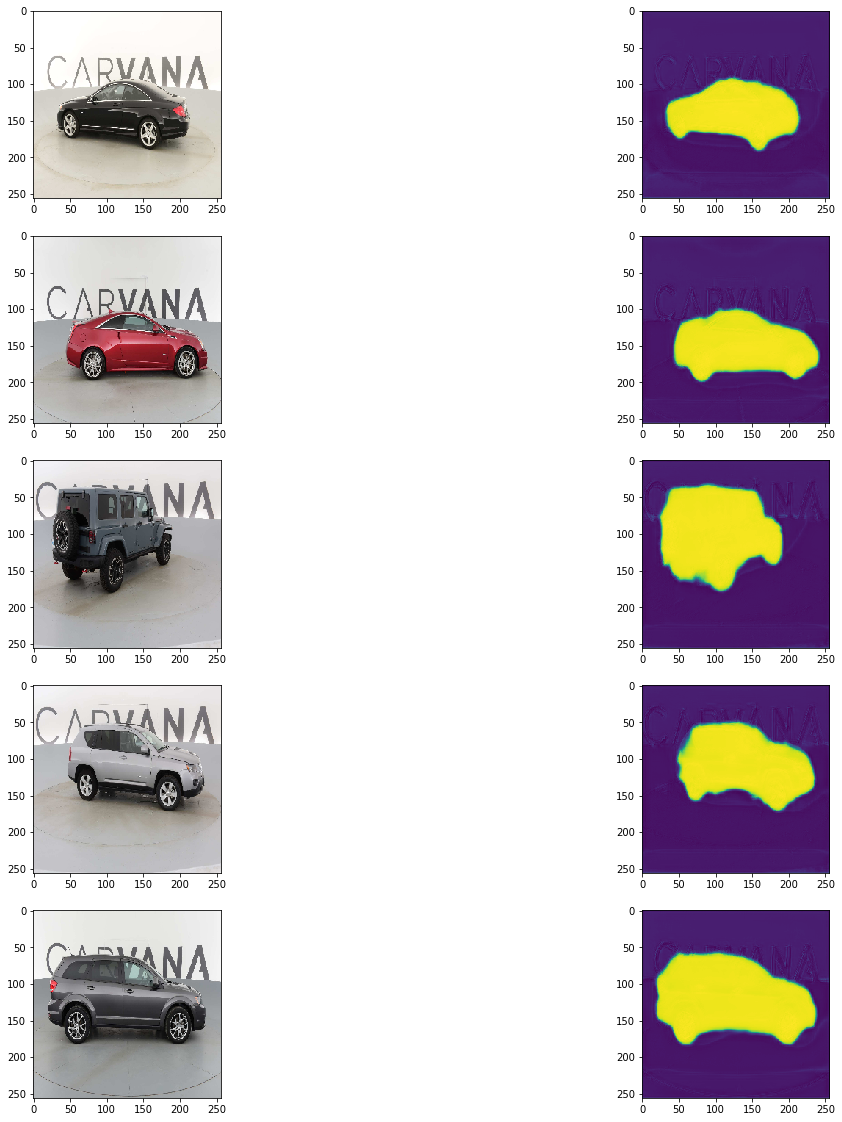

Epoch 1/3 ... training IOU loss 0.7070497274398804 ... Validation IOU loss 0.7894545197486877
Epoch 1/3 ... training IOU loss 0.8241017460823059 ... Validation IOU loss 0.802191972732544
Epoch 1/3 ... training IOU loss 0.841230571269989 ... Validation IOU loss 0.8089708089828491
Epoch 1/3 ... training IOU loss 0.8374162316322327 ... Validation IOU loss 0.8210545778274536
Epoch 1/3 ... training IOU loss 0.8114749789237976 ... Validation IOU loss 0.8338084816932678
Epoch 1/3 ... training IOU loss 0.8323346972465515 ... Validation IOU loss 0.8440248966217041
Epoch 1/3 ... training IOU loss 0.8146233558654785 ... Validation IOU loss 0.8512077927589417
Epoch 1/3 ... training IOU loss 0.8685034513473511 ... Validation IOU loss 0.8601304292678833
Epoch 1/3 ... training IOU loss 0.8702731728553772 ... Validation IOU loss 0.8683828115463257
Epoch 1/3 ... training IOU loss 0.893036425113678 ... Validation IOU loss 0.8764193654060364


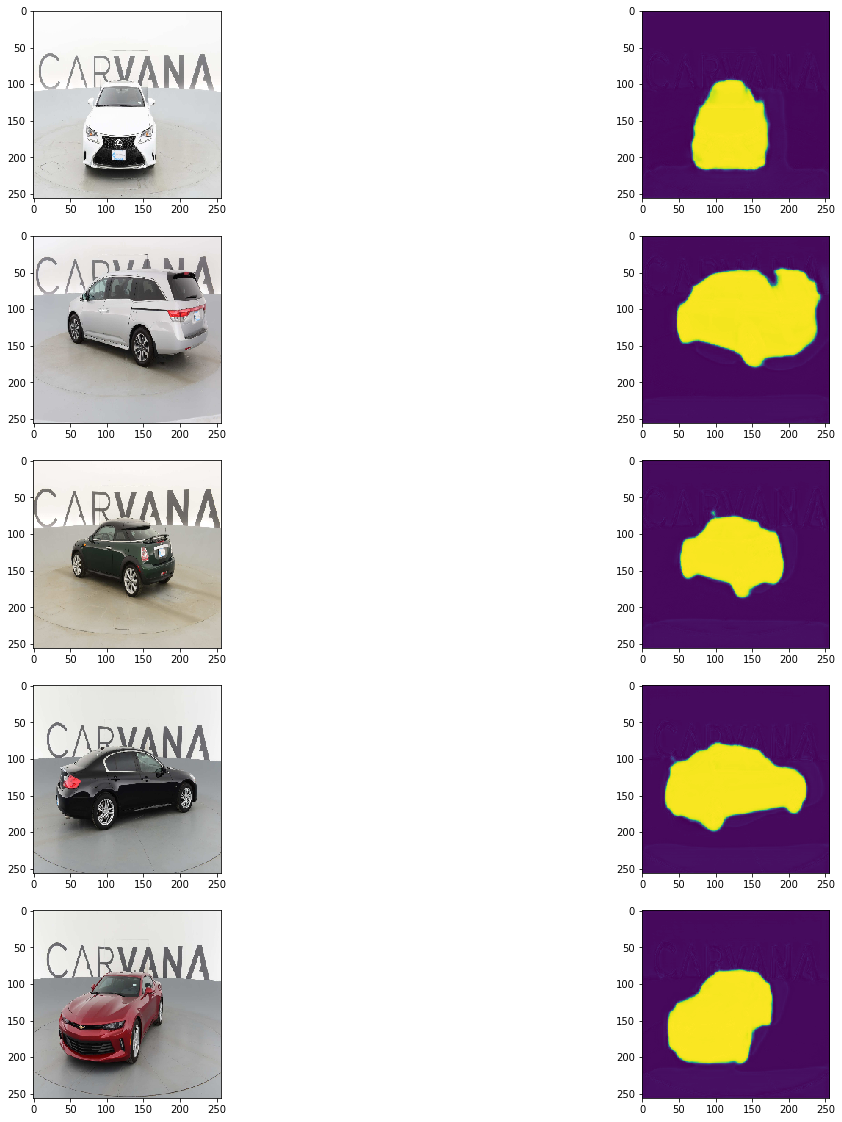

Epoch 1/3 ... training IOU loss 0.8897214531898499 ... Validation IOU loss 0.8837840557098389
Epoch 1/3 ... training IOU loss 0.8909701704978943 ... Validation IOU loss 0.8909996151924133
Epoch 1/3 ... training IOU loss 0.9062741994857788 ... Validation IOU loss 0.8959694504737854
Epoch 1/3 ... training IOU loss 0.897679328918457 ... Validation IOU loss 0.8989295363426208
Epoch 1/3 ... training IOU loss 0.8776345252990723 ... Validation IOU loss 0.9056942462921143
Epoch 1/3 ... training IOU loss 0.9237529635429382 ... Validation IOU loss 0.9025341868400574
Epoch 1/3 ... training IOU loss 0.9106563329696655 ... Validation IOU loss 0.9071172475814819
Epoch 1/3 ... training IOU loss 0.9256317019462585 ... Validation IOU loss 0.9113134145736694
Epoch 1/3 ... training IOU loss 0.9282374978065491 ... Validation IOU loss 0.9117308259010315
Epoch 1/3 ... training IOU loss 0.9139478206634521 ... Validation IOU loss 0.9136211276054382


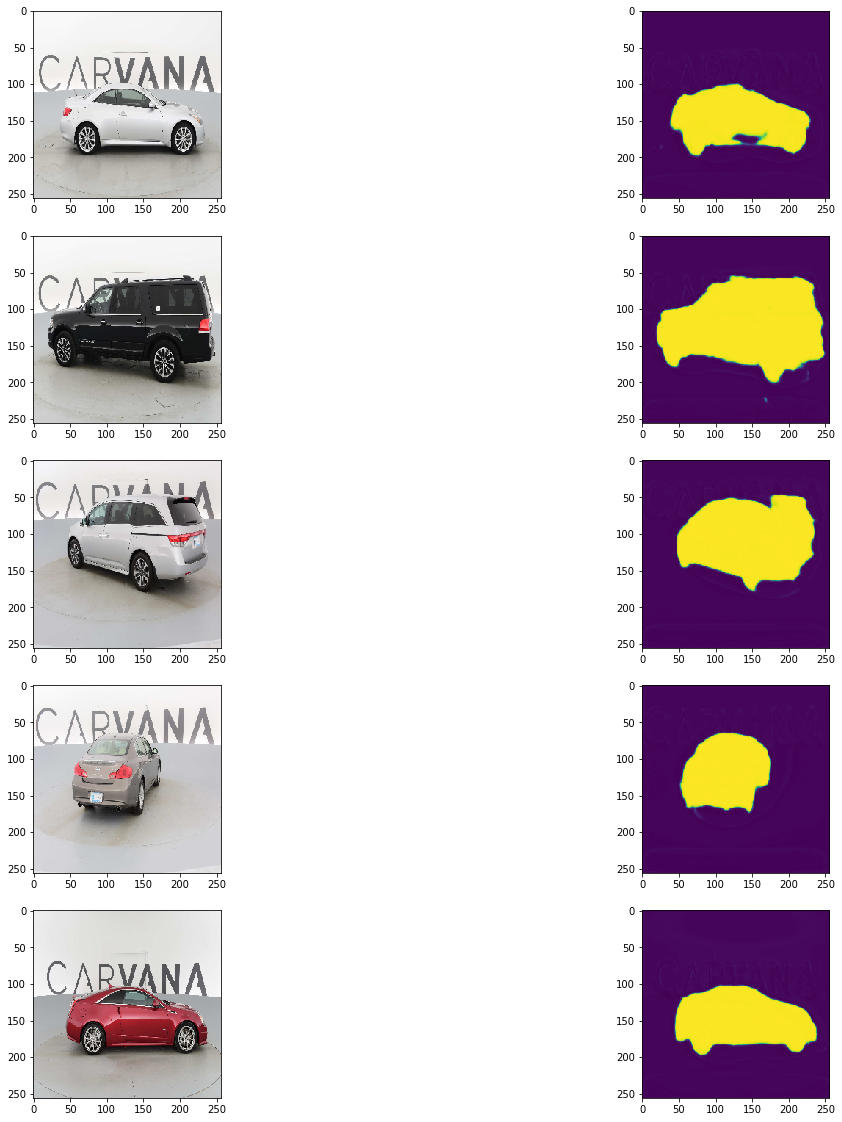

Epoch 1/3 ... training IOU loss 0.920559823513031 ... Validation IOU loss 0.9188166260719299
Epoch 1/3 ... training IOU loss 0.9106982350349426 ... Validation IOU loss 0.925658106803894
Epoch 1/3 ... training IOU loss 0.9227073788642883 ... Validation IOU loss 0.9253708720207214
Epoch 1/3 ... training IOU loss 0.9241430759429932 ... Validation IOU loss 0.9320060014724731
Epoch 1/3 ... training IOU loss 0.9090862274169922 ... Validation IOU loss 0.929582417011261
Epoch 1/3 ... training IOU loss 0.9423255324363708 ... Validation IOU loss 0.9355201125144958
Epoch 1/3 ... training IOU loss 0.9434522986412048 ... Validation IOU loss 0.9367901682853699
Epoch 1/3 ... training IOU loss 0.9482957124710083 ... Validation IOU loss 0.9434199333190918
Epoch 1/3 ... training IOU loss 0.9464508891105652 ... Validation IOU loss 0.9420188069343567
Epoch 1/3 ... training IOU loss 0.9245102405548096 ... Validation IOU loss 0.945712685585022


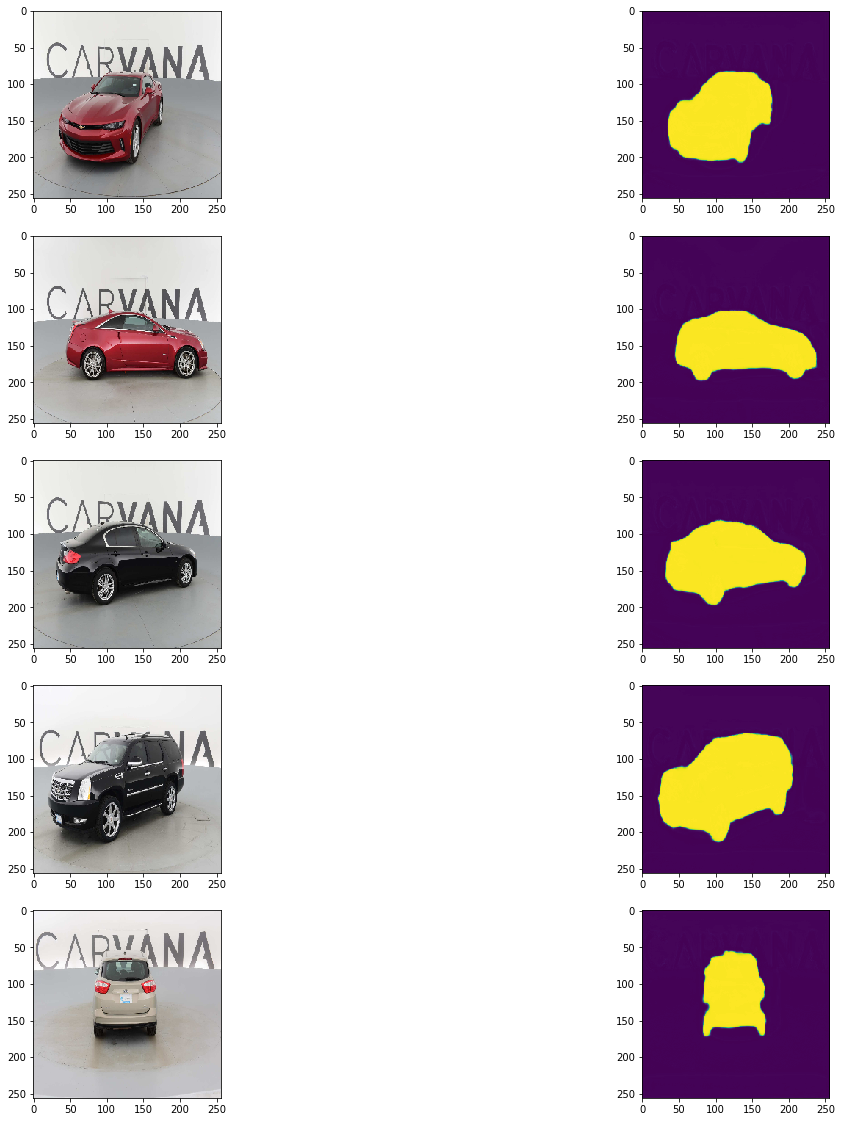

Epoch 1/3 ... training IOU loss 0.942263126373291 ... Validation IOU loss 0.9458682537078857
Epoch 1/3 ... training IOU loss 0.9440194964408875 ... Validation IOU loss 0.9476656913757324
Epoch 1/3 ... training IOU loss 0.9570082426071167 ... Validation IOU loss 0.9509250521659851
Epoch 1/3 ... training IOU loss 0.9562482833862305 ... Validation IOU loss 0.95229172706604
Epoch 1/3 ... training IOU loss 0.9591751098632812 ... Validation IOU loss 0.9546641111373901
Epoch 1/3 ... training IOU loss 0.9470107555389404 ... Validation IOU loss 0.9553897380828857
Epoch 1/3 ... training IOU loss 0.942184567451477 ... Validation IOU loss 0.9523299932479858
Epoch 1/3 ... training IOU loss 0.9699311256408691 ... Validation IOU loss 0.9540738463401794
Epoch 1/3 ... training IOU loss 0.9597277045249939 ... Validation IOU loss 0.9557603597640991
Epoch 1/3 ... training IOU loss 0.9662468433380127 ... Validation IOU loss 0.9592026472091675


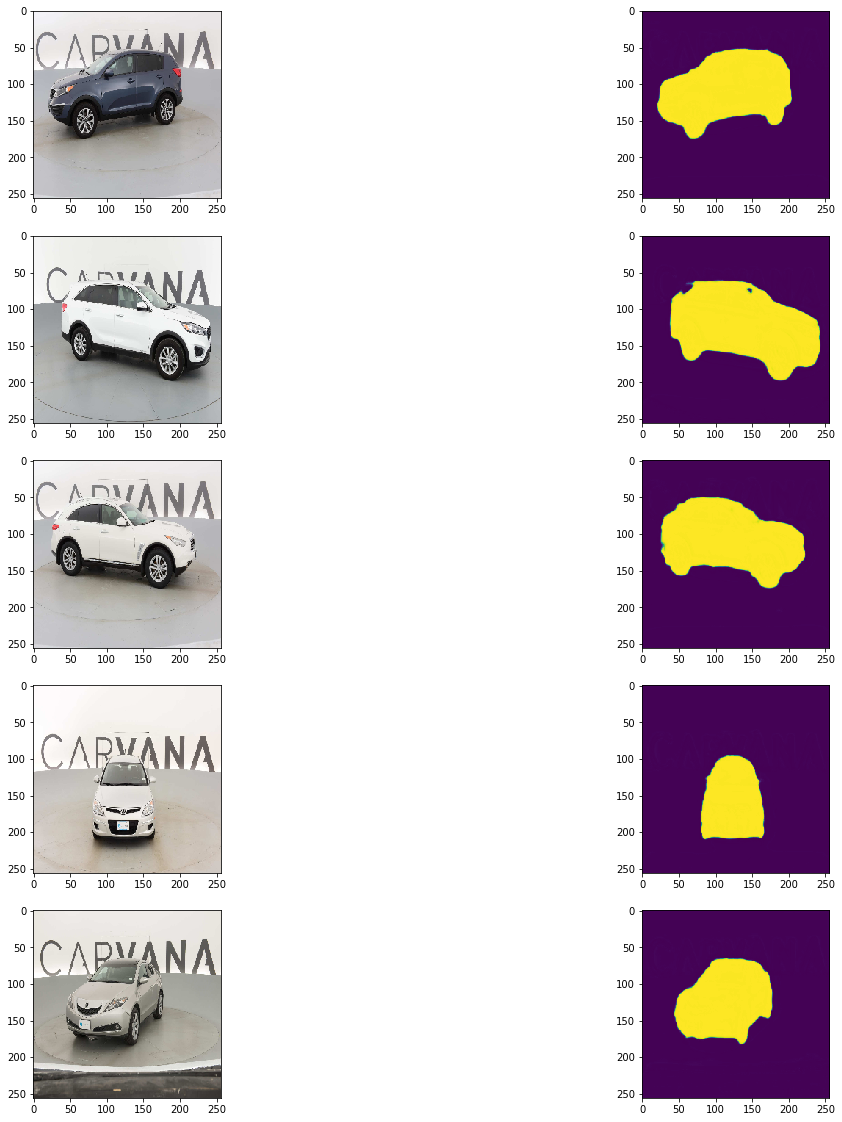

Epoch 1/3 ... training IOU loss 0.9663403034210205 ... Validation IOU loss 0.9613307118415833
Epoch 1/3 ... training IOU loss 0.9679120779037476 ... Validation IOU loss 0.9618745446205139
Epoch 1/3 ... training IOU loss 0.964989185333252 ... Validation IOU loss 0.9569563865661621
Epoch 1/3 ... training IOU loss 0.9538917541503906 ... Validation IOU loss 0.9573019742965698
Epoch 1/3 ... training IOU loss 0.9624875783920288 ... Validation IOU loss 0.9626505374908447
Epoch 1/3 ... training IOU loss 0.9681930541992188 ... Validation IOU loss 0.964931309223175
Epoch 1/3 ... training IOU loss 0.9497874975204468 ... Validation IOU loss 0.9624366760253906
Epoch 1/3 ... training IOU loss 0.9537671804428101 ... Validation IOU loss 0.9659100770950317
Epoch 1/3 ... training IOU loss 0.9653297066688538 ... Validation IOU loss 0.9627005457878113
Epoch 1/3 ... training IOU loss 0.9699760675430298 ... Validation IOU loss 0.9651293158531189


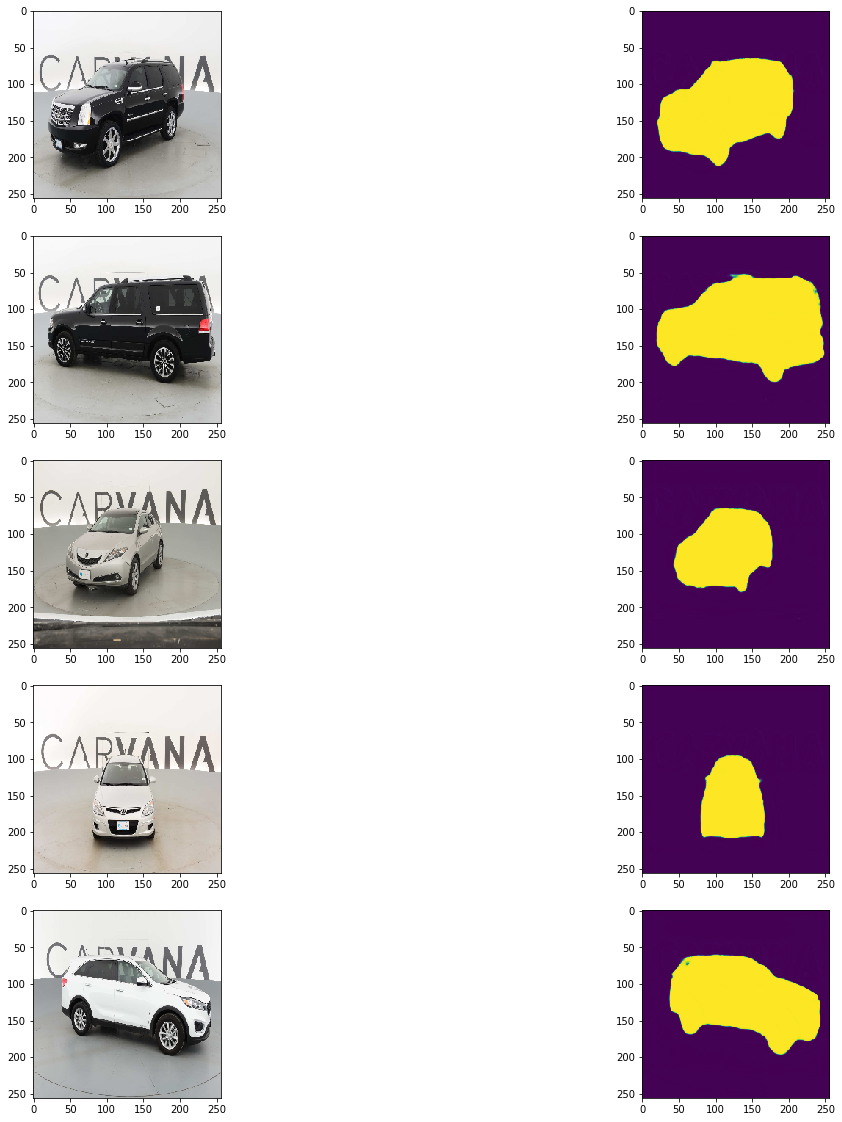

Epoch 1/3 ... training IOU loss 0.9733201265335083 ... Validation IOU loss 0.9676001667976379
Epoch 1/3 ... training IOU loss 0.9710359573364258 ... Validation IOU loss 0.9677131175994873
Epoch 1/3 ... training IOU loss 0.9532450437545776 ... Validation IOU loss 0.9633382558822632
Epoch 1/3 ... training IOU loss 0.9763003587722778 ... Validation IOU loss 0.9688342809677124
Epoch 1/3 ... training IOU loss 0.958181619644165 ... Validation IOU loss 0.9661182165145874
Epoch 1/3 ... training IOU loss 0.9728981256484985 ... Validation IOU loss 0.9639743566513062
Epoch 1/3 ... training IOU loss 0.9676386713981628 ... Validation IOU loss 0.9693172574043274
Epoch 1/3 ... training IOU loss 0.9698009490966797 ... Validation IOU loss 0.9710942506790161
Epoch 1/3 ... training IOU loss 0.9773154854774475 ... Validation IOU loss 0.9698537588119507
Epoch 1/3 ... training IOU loss 0.972312331199646 ... Validation IOU loss 0.9701858758926392


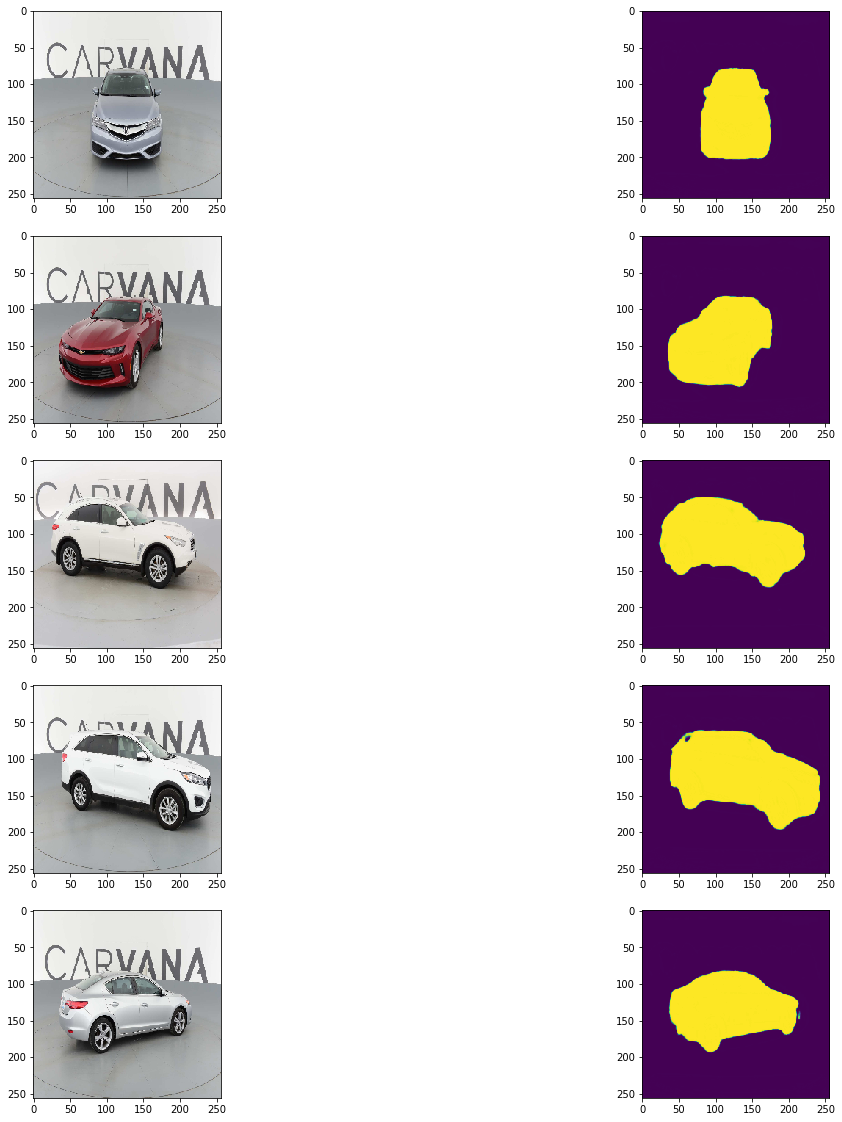

Epoch 1/3 ... training IOU loss 0.9742536544799805 ... Validation IOU loss 0.9604448676109314
Epoch 1/3 ... training IOU loss 0.9694002866744995 ... Validation IOU loss 0.9717090129852295


In [ ]:
main()

In [ ]:
x = 1